**Experiment-6**

**Aim: Apply value iteration algorithm to specific application.**

**Theory:**
Value Iteration (VI) is an algorithm used to solve RL problems like the golf example mentioned above, where we have full knowledge of all components of the MDP. It works by iteratively improving its estimate of the ‘value’ of being in each state. It does this by considering the immediate rewards and expected future rewards when taking different available actions. These values are tracked using a value table, which updates at each step. Eventually, this sequence of improvements converges, yielding an optimal policy of state → action mappings that the agent can follow to make the best decisions in the given environment.
VI leverages the concept of dynamic programming, where solving a big problem is broken down into smaller subproblems. To achieve this in VI, the Bellman equation is used to guide the process of iteratively updating value estimates for each state, providing a recursive relationship that expresses the value of a state in terms of the values of its neighbouring states.


**Working:**

The image below depicts the steps of the algorithm. Don’t be put off, it's easier than it appears.

![](Value_Iteration-1.png?raw=true)


1. Initialisation: Now we have the parameters defined, we want to initialise our value function V(s) for all states in S. This typically means we set all values to 0 (or some other arbitrary constant) for every state. Think of the value function as a table that tracks a value for each state, updating frequently.
A table with two columns, S and V(S). In S there are cells with states s1 and s2. In V(s) there are cells with values of zero and zero.
An initialised value table
2. Outer loop: Now everything is set up, we can start the iterative process of updating our values. We begin in the outer loop, which repeats until the convergence criteria are met (until Δ < θ).
At each pass of the outer loop, we begin by setting Δ = 0. Delta Δ is used to represent the change in value estimates across all states, and the algorithm continues iterating until this change Δ falls below the specified threshold θ.
3. Inner loop: For every state s in S, we:
set a variable v to the current value of that state V(s), remember - this is fetched from our value table (so on the first pass, v = V(s) = 0)
perform the bellman equation to update V(s)
update Δ (we’ll come back to this)

The Bellman Equation

![](Unknown.jpeg?raw=true)


This line of the algorithm is the most important. It requires that we update the value of the current state we are looking at in the loop. This value is calculated by considering all available actions from that specific state (a 1-step look ahead). When we take each of those possible actions it will present us with a set of possible next states s′ and respective rewards r.

So, for each of those next states s′ and respective rewards r, we perform p(s′, r|s, a)[r + γV(s′)]. Let's break this up:
1. p(s′, r|s, a) the probability of being in state s, taking action a, and ending up in next state s′ (this is just our transition function)
2. [r + γV(s′)] the reward r of ending up in next state s′ (we get that from our reward function) + our discount γ * by the value of that next state s′ (we get that from our value table)

3. We then multiply these two parts p(s′, r|s, a) * [r + γV(s′)]

Remember, this calculation is just for one next state s′ (the third level of the tree), we need to repeat this for each possible next state s′ after taking a.
Once we have done this, we sum all the results we just got Σₛ′, ᵣ p(s′, r|s, a) * [r + γV(s′)]. We then repeat this for each action a (the second level in the tree).
Once these steps are complete, we will have a value associated with each possible action a from the current state we are looking at in the inner loop s. We choose the highest using maxₐ and set this equal to our new value for that state V(s)←maxₐ Σₛ′, ᵣ p(s′, r|s, a) * [r + γV(s′)].

**Advantages:**

1. Finds the optimal policy: Value iteration, if allowed to fully converge, is guaranteed to find the optimal policy for a given Markov Decision Process. This means it finds the policy that maximizes the expected sum of discounted future rewards.
2. Conceptual simplicity: The core idea of value iteration is relatively straightforward: iterate over state values, updating them based on the best possible future expected rewards. This can make it easier to understand than policy iteration.
3. No direct policy evaluation: Unlike policy iteration, value iteration doesn't require an explicit policy evaluation step.

**Disadvantages:**
1. Computational expense: Value iteration sweeps through the entire state space in each iteration. This can be computationally very expensive for problems with large numbers of states.
2. Slow convergence: In some cases, value iteration can take many iterations to converge to the optimal value function, especially if the discount factor is close to 1.
3. Requires a model: Value iteration needs a full model of the environment (the transition probabilities and rewards for all state-action pairs). This isn't always available in real-world reinforcement learning scenarios.

**Examples:**
1. Grid world problem.
2. Resource allocation.
3. Inventory management.
4. Simple gambling games.

In [1]:
from typing import Tuple, Dict, Optional, Iterable, Callable
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import gym
from gym import spaces
from gym.error import DependencyNotInstalled
import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
            np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
        )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

In [2]:
env = Maze()

In [3]:
env.reset()

(0, 0)

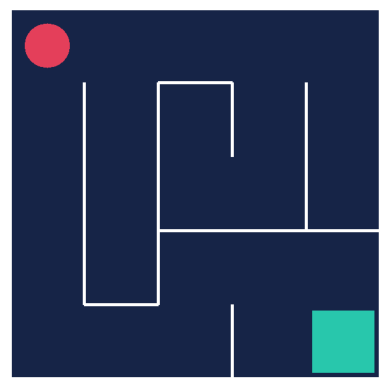

In [4]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [5]:
print(f"Observation space: {env.observation_space}")
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space: MultiDiscrete([5 5])
Observation space shape: [5 5]
Number of actions: 4


In [6]:
policy_probs = np.full((5,5,4),0.25)

In [7]:
policy_probs

array([[[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]])

In [8]:
def policy(state):
    return policy_probs[state]

In [9]:
action_probabilities = policy((0,0))
for action, prob in zip(range(5), action_probabilities):
    print(f"Probability of taking action: {action}: {prob}")

Probability of taking action: 0: 0.25
Probability of taking action: 1: 0.25
Probability of taking action: 2: 0.25
Probability of taking action: 3: 0.25


In [10]:
test_agent(env, policy, episodes=1)

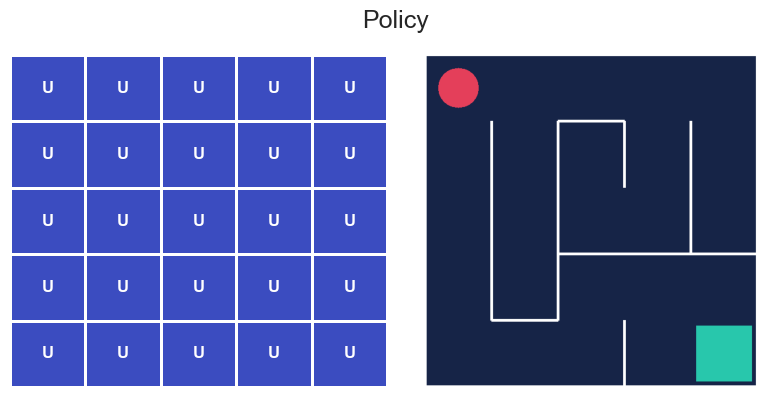

In [11]:
plot_policy(policy_probs, frame)

In [12]:
state_values = np.zeros(shape=(5,5))

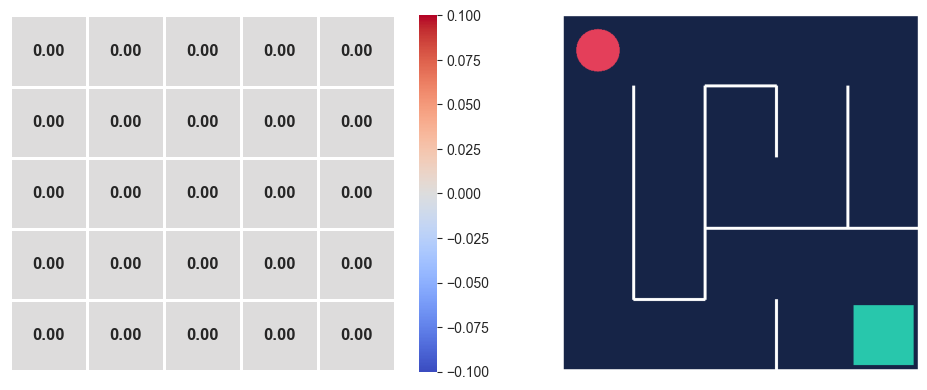

In [13]:
plot_values(state_values, frame)

In [14]:
def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float("inf")
    while delta > theta:
        delta = 0
        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)]
                action_probs = None
                max_qsa = float("-inf")
                for action in range(4):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    qsa = reward + gamma * state_values[next_state]
                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4)
                        action_probs[action] = 1
                state_values[(row, col)] = max_qsa
                policy_probs[(row, col)] = action_probs
                delta = max(delta, abs(max_qsa-old_value))     

In [15]:
value_iteration(policy_probs, state_values)

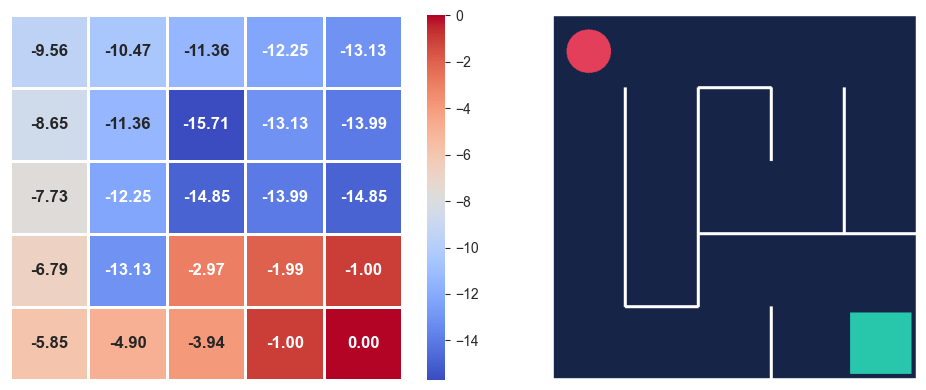

In [16]:
plot_values(state_values, frame)

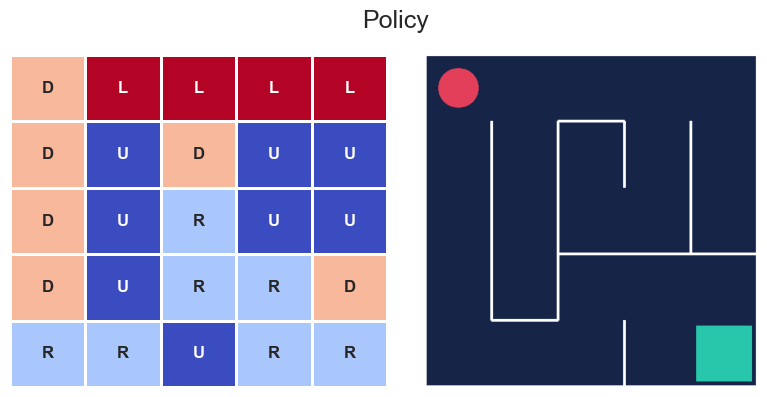

In [17]:
plot_policy(policy_probs, frame)

In [18]:
test_agent(env, policy)

**Conclusion:**

In this experiement we learnt about value iteration algorithm, which is a fundamental algorithm in reinforcement learning used to find optimal policies in a Markov Decision Process (MDP). An MDP models an environment where an agent takes actions, moves between states, and receives rewards. The goal of the agent is to learn a policy (a mapping from states to actions) that maximizes its expected cumulative reward.